In [1]:
%run init_notebook.py

In [2]:
from statsmodels.regression.linear_model import OLS

import matplotlib.lines as mlines

import pymc as pm
from patsy import dmatrix

In [3]:
from src.utils import get_dt_index, load_pd_df, get_samp
from src.processing import get_fitted_dist

In [5]:
# load data

In [6]:
data = load_pd_df('hhp.feather')

In [7]:
df = df[df.inflexppoint.abs() <=12]
data.inflexppoint /= 100

NameError: name 'df' is not defined

In [11]:
# inflation

In [ ]:
infl = get_dt_index(load_pd_df('de_inf_prepro.csv'))
infl.sort_index(inplace=True)
infl['y_m'] = infl.index.to_period('M').astype(str)

In [14]:
# bei

In [15]:
bei = get_dt_index(load_pd_df('bei.csv'))
bei.sort_index(inplace=True)
bei['y_m'] = bei.index.to_period('M').astype(str)

In [11]:
# plot

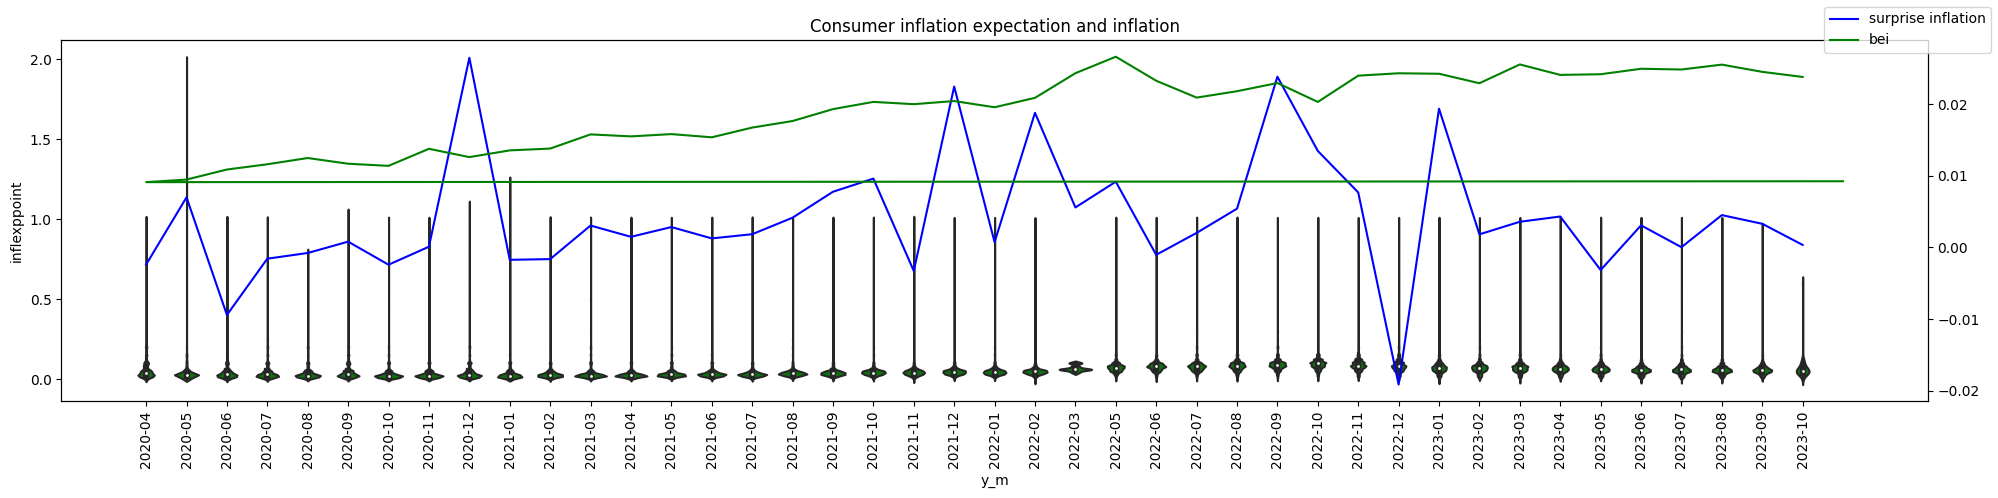

In [17]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))
sns.violinplot(data=df[df.inflexppoint <=10], x='y_m', y='inflexppoint', ax=ax, color='green', alpha=.5, label='consumer infl. expect.')
ax2 = ax.twinx()
ax2.plot(infl.loc[df.date.min(): df.date.max()].set_index('y_m').resid, color='blue', label='surprise inflation')
# ax2.plot(infl.loc[df.date.min(): df.date.max()].set_index('y_m').pi_de, color='red', label='realised inflation')
ax2.plot(bei.loc[df.date.min(): df.date.max()].groupby('y_m').first().bei, color='green', label='bei')

ax.tick_params(axis='x', rotation=90)
fig.legend()
plt.title('Consumer inflation expectation and inflation')

plt.tight_layout()

fig.savefig(os.path.join(GRAPHS_DIR, 'presentation3_graph3.png'))

In [28]:
# anlayse panel dim

In [45]:
sub = df.set_index('id').reset_index().pivot_table(values='inflexppoint', index='date', columns='id').copy()
sub.dropna(axis=0, thresh=1, inplace=True)

In [46]:
sub = sub.loc[:, sub.max() <= .5]

''

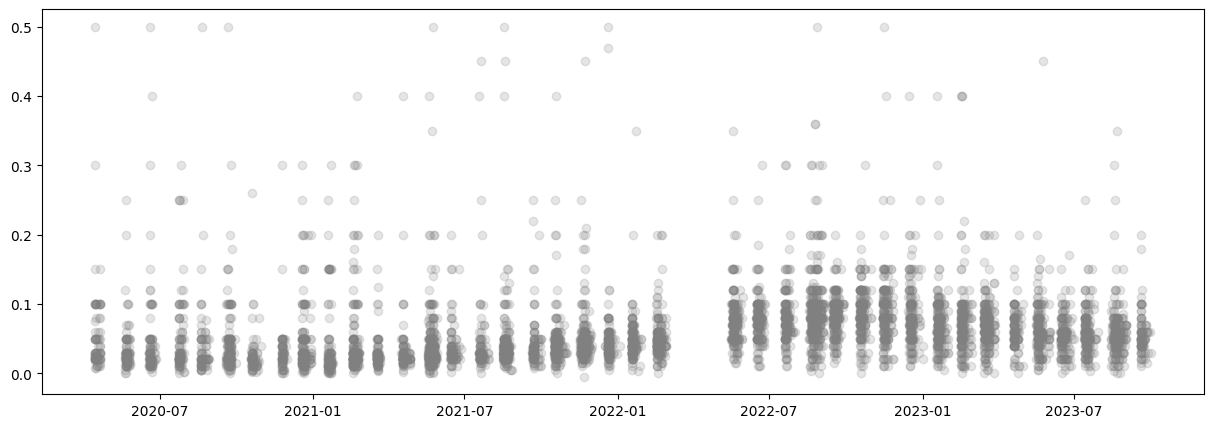

In [47]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
plt.plot(sub.iloc[:, get_samp(sub.shape[1], 2_000)], linewidth=0, marker='o', alpha=.2, color='grey')
;

In [48]:
# impute missing data

In [50]:
sub['week'] = sub.index.to_period("W")

In [93]:
X = sub.groupby('week').first().copy()
X.index = X.index.start_time

In [94]:
min_count = 40
impute_share = .1
thresh = int(min_count - min_count * impute_share)

In [95]:
thresh

36

In [96]:
X.count(axis=1).quantile(.1)

35.1

In [97]:
X = X.loc[X.count(axis=1) >= thresh]

In [98]:
X.shape

(100, 47286)

In [99]:
def get_homogeneous_shape(srs: pd.Series, target_count, dists: list = ['gamma', 'norm']):
    arr = srs.dropna().values
    if len(arr) < target_count:
        arr = srs.dropna().values
        dist = get_fitted_dist(arr, dists=dists)
        return np.concatenate([arr, dist.rvs(target_count - len(arr))])
    else:
        return arr[get_samp(len(arr), target_count)]
    

In [100]:
X = pd.DataFrame(X.apply(lambda x: get_homogeneous_shape(x, min_count), axis=1).to_dict()).T

In [101]:
X.shape

(100, 40)

''

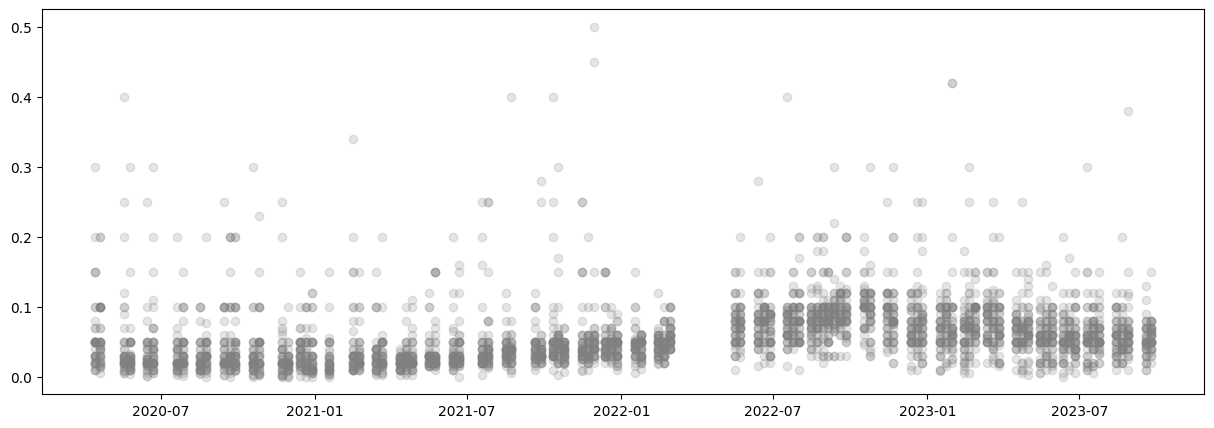

In [102]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
plt.plot(X, linewidth=0, marker='o', alpha=.2, color='grey')
;

In [103]:
# model

In [174]:
num_knots = int(X.shape[0] / 8)
knot_list = np.linspace(0, X.shape[0], num_knots+2)[1:-1]
num_knots

12

In [175]:
B = dmatrix(
    "bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",
    {"cnt": [*range(0, X.shape[0])], "knots": knot_list[1:-1]})

In [176]:
with pm.Model() as infl_exp:
    τ = pm.HalfCauchy("τ", beta=1) 
    # β = pm.GaussianRandomWalk("β", mu=0, sigma=τ, shape=(B.shape[1],1))
    β = pm.Normal("β", mu=0, sigma=τ, shape=(B.shape[1], 1))
    μ = pm.Deterministic("μ", pm.math.dot(B.base, β))
    σ = pm.HalfNormal("σ", sigma=1)
    pm.Normal("likelihood", mu=μ, sigma=σ, observed=X)
    
    # pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y)
    
    infl_exp_prior_pred = pm.sample_prior_predictive()

Sampling: [likelihood, β, σ, τ]


''

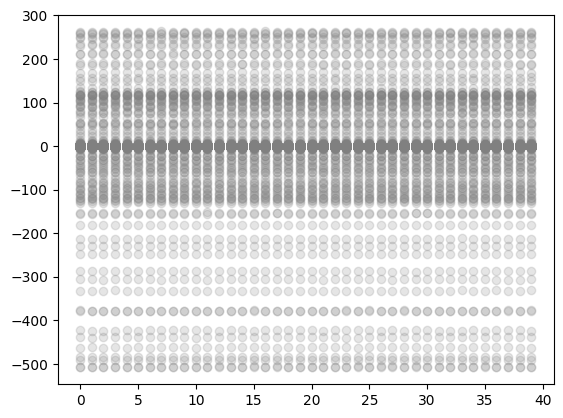

In [177]:
plt.plot(
    infl_exp_prior_pred.prior_predictive.likelihood.values[0, get_samp(500, 10), :, :].reshape(10 * X.shape[0], X.shape[1]).T,
    linewidth=0,
    marker='o',
    alpha=.2,
    color='grey',
)
;

In [178]:
with infl_exp:
    infl_exp_trace = pm.sample(1000, return_inferencedata=True)
    infl_exp_post_pred = pm.sample_posterior_predictive(trace=infl_exp_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
Sampling: [likelihood]


In [180]:
X['M'] = X.index.to_period('M')
infl['M'] = infl.index.to_period('M')
pi = pd.merge(X.reset_index(), infl[['pi_de_surprise_Y', 'M']], on='M', how='left').set_index('index').pi_de_surprise_Y
X.drop('M', axis=1, inplace=True)

C:\Users\LukasGrahl\AppData\Local\Temp\ipykernel_9948\1017396192.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(os.path.join(GRAPHS_DIR, 'presentation3_graph6.png'))


''

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


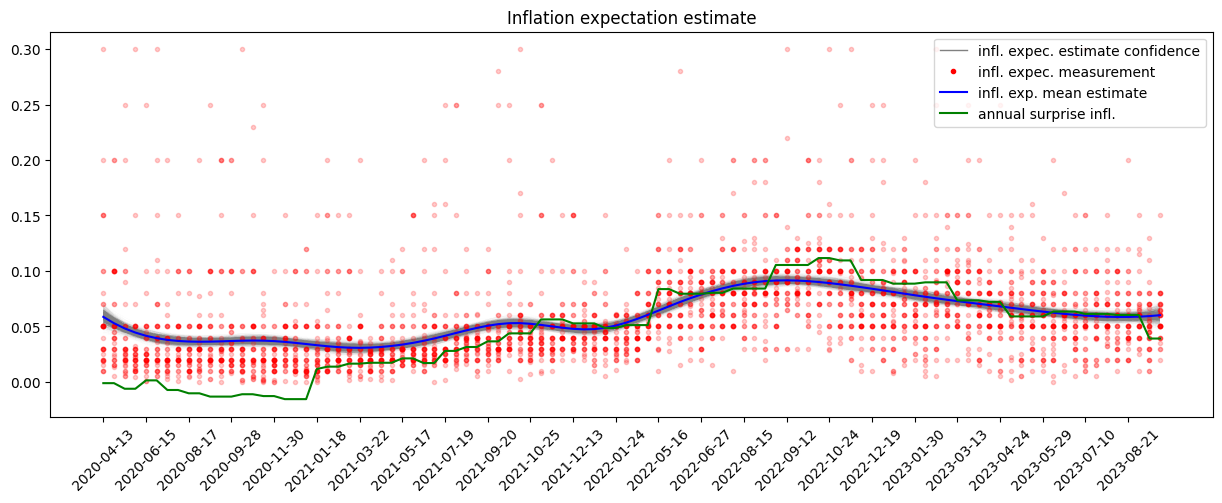

In [188]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(
    infl_exp_trace.posterior['μ'][:, get_samp(1_000, 500)].values.reshape(4 * 500, X.shape[0]).T,
    linewidth=.1,
    # marker='.',
    alpha=.05,
    color='grey',
)
h1 = mlines.Line2D([], [], linewidth=1, color='grey', label='infl. expec. estimate confidence')

# ax.plot(np.array([np.quantile(X.values, i/100, axis=1) for i in range(15, 90, 5)]).T, color='red', linewidth=0, marker='.', alpha=.5)
ax.plot(X[X <= .3].values, color='red', linewidth=0, marker='.', alpha=.2)
h2 = mlines.Line2D([], [], linewidth=0, marker='.', color='red', label='infl. expec. measurement')

ax.plot(infl_exp_trace.posterior['μ'][:, get_samp(1_000)].values.reshape(4 * 100, X.shape[0]).T.mean(axis=1), color='blue')
h3 = mlines.Line2D([], [], color='blue', label='infl. exp. mean estimate')

ax.plot(pi.values, color='green')
h4 = mlines.Line2D([], [], color='green', label='annual surprise infl.')

plt.legend(handles=[h1, h2, h3, h4])

ax.set_xticks([*range(0, X.shape[0])][0::4])
ax.set_xticklabels(list(X.index.astype(str))[0::4], rotation=45)

plt.title('Inflation expectation estimate')
fig.savefig(os.path.join(GRAPHS_DIR, 'presentation3_graph6.png'))
;

In [282]:
# save data

In [283]:
arr = np.concatenate(
    [
        np.expand_dims(infl_exp_trace.posterior['μ'][:, get_samp(1_000, 200)].values.reshape(4 * 200, X.shape[0]).max(axis=0), axis=1),
        np.expand_dims(infl_exp_trace.posterior['μ'][:, get_samp(1_000, 200)].values.reshape(4 * 200, X.shape[0]).min(axis=0), axis=1),
        np.expand_dims(infl_exp_trace.posterior['μ'][:, get_samp(1_000)].values.reshape(4 * 100, X.shape[0]).T.mean(axis=1), axis=1)
    ],
    axis=1
)
df = pd.DataFrame(arr, index=X.index, columns=['pi_e_estimate_max', 'pi_e_estimate_min', 'pi_e_estimate_mean'])
df.to_feather(os.path.join(DATA_DIR, 'infl_expec.feather'))

In [284]:
# inflation expectation and lagged surprises

In [285]:
df['M'] = df.index.to_period('M')
infl_lag = pd.merge(df[['pi_e_estimate_mean', 'M']], infl[['pi_de_surprise_Y', 'M']], on='M', how='left').copy()

infl_lag = infl_lag.join(
    pd.concat([infl_lag['pi_de_surprise_Y'].shift(i).rename(f'pi_surp_Y_lag{i}') for i in range(1, 11)], axis=1).dropna()
)

infl_lag.dropna(inplace=True)

infl_lag = infl_lag.drop_duplicates('M', keep='last').set_index('M')

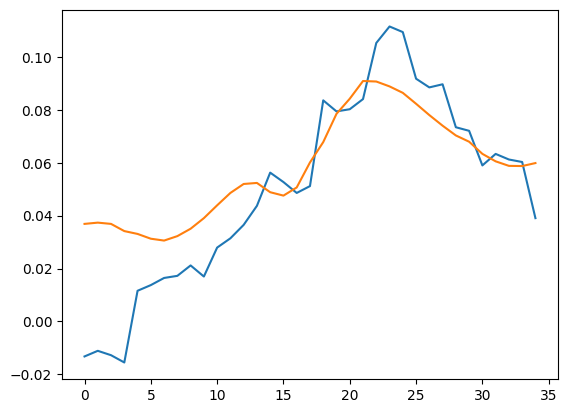

In [286]:
plt.plot(infl_lag[['pi_de_surprise_Y', 'pi_e_estimate_mean']].values)

In [287]:
ols = OLS(infl_lag['pi_e_estimate_mean'], infl_lag.drop('pi_e_estimate_mean', axis=1)).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     pi_e_estimate_mean   R-squared (uncentered):                   0.893
Model:                            OLS   Adj. R-squared (uncentered):              0.844
Method:                 Least Squares   F-statistic:                              18.24
Date:                Sun, 28 Jan 2024   Prob (F-statistic):                    4.74e-09
Time:                        11:34:26   Log-Likelihood:                          87.587
No. Observations:                  35   AIC:                                     -153.2
Df Residuals:                      24   BIC:                                     -136.1
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
pi_de_surprise_Y     1.7684      0.890      1.987      0.058      -0.068       3.605
pi_surp_Y_lag1      -1.1406      1.068     -1.068      0.296      -3.345       1.064
pi_surp_Y_lag2       0.4929      0.872      0.565      0.577      -1.307       2.293
pi_surp_Y_lag3      -0.0724      1.105     -0.066      0.948      -2.353       2.208
pi_surp_Y_lag4      -0.0022      1.049     -0.002      0.998      -2.167       2.162
pi_surp_Y_lag5      -0.1522      0.882     -0.173      0.864      -1.972       1.668
pi_surp_Y_lag6      -0.1130      0.971     -0.116      0.908      -2.117       1.891
pi_surp_Y_lag7       0.1065      0.937      0.114      0.910      -1.827       2.040
pi_surp_Y_lag8       0.0302      1.089      0.028      0.978      -2.217       2.277
pi_surp_Y_lag9       0.3011      1.184      0.254      0.801      -2.142       2.744
pi_surp_Y_lag10     -0.2830      0.763     -0.371      0.714      -1.858       1.292
==============================================================================
Omnibus:                        7.459   Durbin-Watson:                   0.387
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                6.146
Skew:                           0.980   Prob(JB):                       0.0463
Kurtosis:                       3.609   Cond. No.                         80.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [288]:
# analyse persistency

In [289]:
sub_change = sub.groupby('week').first().copy()
sub_change.index = sub_change.index.start_time

sub_change = sub_change.loc[:, sub_change.count() > 10]
sub_change['M'] = sub_change.index.to_period('M')

sub_change = pd.merge(sub_change.reset_index(), infl[['pi_de_surprise_Y', 'M']].copy(), on='M', how='left')
sub_change = sub_change.drop('M', axis=1).set_index('week')

In [290]:
import statsmodels.api as sm

In [291]:
for col in sub_change.drop('pi_de_surprise_Y', axis=1).columns:
    srs = sub_change[col].dropna().copy()
    # resid = OLS(srs, sm.add_constant(sub_change.loc[srs.index, 'pi_de_surprise_Y'])).fit().resid
    resid = OLS(srs, sub_change.loc[srs.index, 'pi_de_surprise_Y']).fit().resid
    
    sub_change.loc[srs.index, col] = resid

In [292]:
sub_change.drop('pi_de_surprise_Y', axis=1, inplace=True)

In [293]:
_ = sub_change.apply(lambda x: (x.dropna() ** 2).mean()).sort_values().copy()
idx, mse = _.index, _.values

''

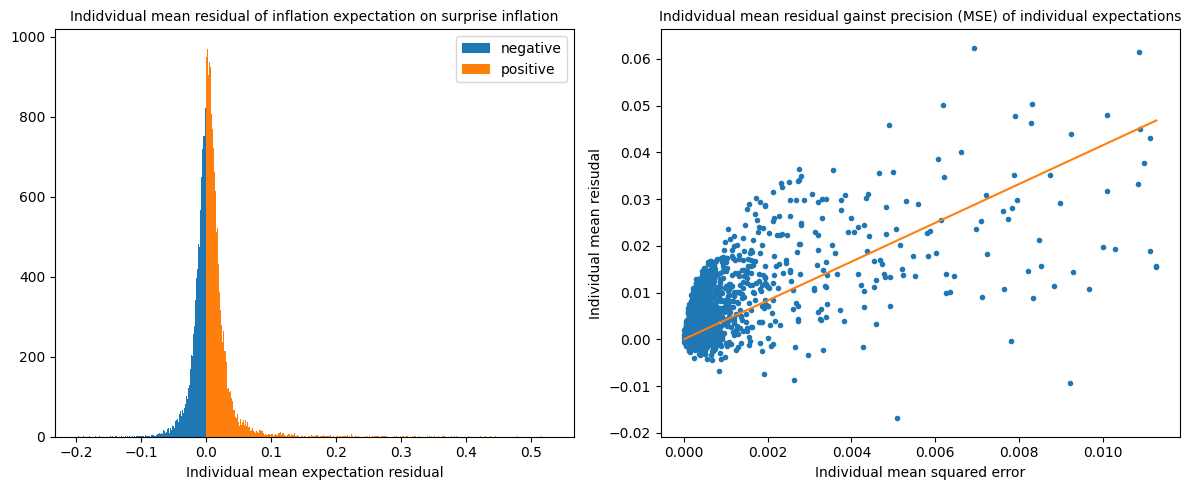

In [295]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
arr_n = sub_change[sub_change < 0].values.ravel()
arr_p = sub_change[sub_change > 0].values.ravel()

arr_n = arr_n[~np.isnan(arr_n)]
arr_p = arr_p[~np.isnan(arr_p)]

ax[0].hist(arr_n, bins='fd')
ax[0].hist(arr_p, bins='fd')

ax[0].legend(['negative', 'positive'])
ax[0].set_xlabel('Individual mean expectation residual')

N = 30
ax[1].plot(mse[:-N], sub_change.loc[:, idx].mean().values[:-N], linewidth=0, marker='.')
ax[1].plot(mse[:-N], OLS(sub_change.loc[:, idx].mean().values[:-N], mse[:-N]).fit().fittedvalues)
ax[1].set_xlabel('Individual mean squared error')
ax[1].set_ylabel('Individual mean reisudal')

ax[0].set_title('Indidvidual mean residual of inflation expectation on surprise inflation', size=10)
ax[1].set_title('Indidvidual mean residual gainst precision (MSE) of individual expectations', size=10)

plt.tight_layout()
fig.savefig(os.path.join(GRAPHS_DIR, 'presentation3_pi_resid.png'))
;
